In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import os
import glob
import pickle

In [17]:
# Define the processed folder path
processed_folder = os.path.abspath(os.path.join('..', 'data', 'processed'))

# List all test and train files
test_files = glob.glob(os.path.join(processed_folder, 'test*'))
train_files = glob.glob(os.path.join(processed_folder, 'train*'))

# Concatenate all test and train files into one DataFrame
data_train = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)
data_test = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)

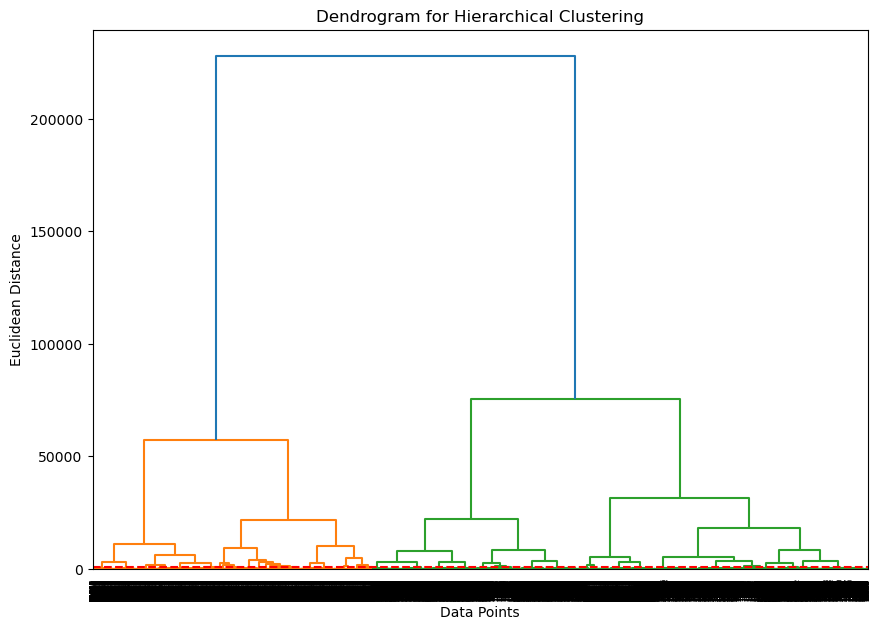

In [18]:
# Perform Hierarchical Clustering
plt.figure(figsize=(10, 7))

# Generate the linkage matrix
Z = sch.linkage(data_train, method='ward')

# Create the dendrogram and plot it
dendrogram = sch.dendrogram(Z)

# Draw a horizontal line at the selected distance to represent the threshold
distance_threshold=700
plt.axhline(y=distance_threshold, color='r', linestyle='--')

plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

In [19]:
# Perform Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=10, linkage='ward') #distance_threshold=distance_threshold,
data_train_labels=hc.fit_predict(data_train)

In [20]:
data_train['class']=data_train_labels.tolist()
# data_train=data_train.drop(data_train[data_train['class']==3].index) # Drop classes with low amount
# data_train['class']=data_train['class'].map({5:3, 0:0, 1:1, 2:2, 4:4})

output_file = os.path.join('..', 'data/processed/data_alltrain_with_labels.csv')
data_train.to_csv(output_file, index=False)

models_dir = os.path.join('..', 'models')
with open(os.path.join(models_dir, f'hierarchical_clustering_model{distance_threshold}.pkl'), 'wb') as file:
    pickle.dump(hc, file)

In [21]:
print(data_train['class'].value_counts())
print(data_train.columns)

class
4     1505
13    1405
8     1263
19    1217
1     1082
25    1031
6      947
20     899
0      896
23     858
14     857
24     854
12     837
18     822
3      821
22     771
38     755
17     746
7      708
27     693
11     682
29     676
31     617
43     600
41     567
46     520
15     463
32     369
42     355
16     294
34     262
37     251
44     215
30     197
36     161
35     144
47      84
40      65
33      40
2        9
10       8
9        8
5        7
28       6
21       6
26       2
45       1
39       1
Name: count, dtype: int64
Index(['price', 'qty', 'isBuyerMaker', 'isBestMatch', 'percent_to_1000',
       'aggregated_trades', 'price_seen_before', 'class'],
      dtype='object')


In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X=data_train[['price','qty','isBuyerMaker','isBestMatch','percent_to_1000','aggregated_trades','price_seen_before']]
y=data_train['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
xgb_clf = xgb.XGBClassifier(
                            objective='multi:softmax', 
                            num_class=6, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'])

xgb_clf.fit(X_train, 
            y_train,
            verbose=1,
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.00219	validation_0-mlogloss:0.05726	validation_1-merror:0.00188	validation_1-mlogloss:0.05559
[1]	validation_0-merror:0.00219	validation_0-mlogloss:0.04411	validation_1-merror:0.00188	validation_1-mlogloss:0.04354
[2]	validation_0-merror:0.00219	validation_0-mlogloss:0.03396	validation_1-merror:0.00188	validation_1-mlogloss:0.03430
[3]	validation_0-merror:0.00219	validation_0-mlogloss:0.02638	validation_1-merror:0.00188	validation_1-mlogloss:0.02771
[4]	validation_0-merror:0.00219	validation_0-mlogloss:0.02051	validation_1-merror:0.00188	validation_1-mlogloss:0.02250
[5]	validation_0-merror:0.00182	validation_0-mlogloss:0.01607	validation_1-merror:0.00188	validation_1-mlogloss:0.01841
[6]	validation_0-merror:0.00125	validation_0-mlogloss:0.01277	validation_1-merror:0.00188	validation_1-mlogloss:0.01546
[7]	validation_0-merror:0.00099	validation_0-mlogloss:0.01040	validation_1-merror:0.00156	validation_1-mlogloss:0.01332
[8]	validation_0-merror:0.00063	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=6, num_parallel_tree=None, ...)

In [24]:
import numpy
predictions=xgb_clf.predict(X_train)
unique, counts = numpy.unique(predictions, return_counts=True)
print(dict(zip(unique, counts)))

{0: 668, 1: 821, 2: 8, 3: 620, 4: 1136, 5: 6, 6: 711, 7: 543, 8: 930, 9: 6, 10: 5, 11: 509, 12: 646, 13: 1070, 14: 633, 15: 338, 16: 230, 17: 553, 18: 619, 19: 925, 20: 653, 21: 2, 22: 560, 23: 648, 24: 643, 25: 792, 26: 2, 27: 519, 28: 5, 29: 516, 30: 155, 31: 470, 32: 270, 33: 31, 34: 200, 35: 108, 36: 117, 37: 183, 38: 545, 39: 1, 40: 50, 41: 424, 42: 265, 43: 431, 44: 170, 46: 380, 47: 65}


In [25]:
predictions = xgb_clf.predict(X_train)

models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

# Save the model with the correct name
with open(os.path.join(models_dir, f'xgb{distance_threshold}.pkl'), 'wb') as file:
    pickle.dump(xgb_clf, file)